In [1]:
#data collection
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#creating csv file
key='e0bd458817d36421f668cc47cd93fa89a04abe8f'
df=pdr.get_data_tiingo('AAPL',api_key=key)
df.to_csv('stock_pred.csv')

In [111]:
#reading csv file
df=pd.read_csv('stock_pred.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-03-18 00:00:00+00:00,105.92,106.50,105.1900,106.34,44205171,24.624995,24.759837,24.455280,24.722640,176820684,0.0,1.0
1,AAPL,2016-03-21 00:00:00+00:00,105.91,107.65,105.1401,105.93,35502678,24.622670,25.027197,24.443679,24.627320,142010712,0.0,1.0
2,AAPL,2016-03-22 00:00:00+00:00,106.72,107.29,105.2100,105.25,32444375,24.810984,24.943502,24.459930,24.469229,129777500,0.0,1.0
3,AAPL,2016-03-23 00:00:00+00:00,106.13,107.07,105.9000,106.48,25703495,24.673817,24.892355,24.620345,24.755188,102813980,0.0,1.0
4,AAPL,2016-03-24 00:00:00+00:00,105.67,106.25,104.8900,105.47,26132955,24.566873,24.701716,24.385534,24.520376,104531820,0.0,1.0


In [112]:
#extracting the 'close' i.e close_price columns
dataf1=df.reset_index()['close']
dataf1.head()

0    105.92
1    105.91
2    106.72
3    106.13
4    105.67
Name: close, dtype: float64

In [113]:
dataf1.shape

(1257,)

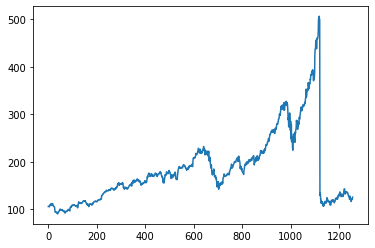

In [114]:
#plotting df1 data
plt.plot(dataf1)

In [31]:
#applying min-max scaler to standarize the data for feeding it to LSTM model
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(dataf1).reshape(-1,1))

In [32]:
#splitting the data into training and test data
train_size=int(len(df1)*0.75)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:]

In [33]:
#shape
print(train_data.shape)
print(test_data.shape)

(942, 1)
(315, 1)


In [34]:
#creating the dataset using time_step
def data_set(data,time_step):
  x_data,y_data=[],[]
  for i in range(len(data)-time_step-1):
    x_data.append(data[i:i+time_step,0])
    y_data.append(data[i+time_step,0])
  return np.array(x_data),np.array(y_data)


In [35]:
time_step=100
x_train,y_train=data_set(train_data,time_step)
x_test,y_test=data_set(test_data,time_step)

In [36]:
#shape of train and test set
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_train)

(841, 100) (841,)
(214, 100) (214,)
[[0.03747444 0.03745039 0.03939868 ... 0.0412267  0.04336741 0.04442574]
 [0.03745039 0.03939868 0.03797956 ... 0.04336741 0.04442574 0.04247745]
 [0.03939868 0.03797956 0.03687312 ... 0.04442574 0.04247745 0.04230908]
 ...
 [0.27737823 0.26999399 0.28113049 ... 0.41226699 0.42150331 0.43384245]
 [0.26999399 0.28113049 0.28502706 ... 0.42150331 0.43384245 0.4247264 ]
 [0.28113049 0.28502706 0.28461816 ... 0.43384245 0.4247264  0.42847865]]


In [37]:
#reshaping x_train and x_test into 3-d i.e ([samples,time_steps,features])
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)


In [38]:
#creating stacked LSTM model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [39]:
model=Sequential()
model.add(LSTM(100,return_sequences=True, input_shape=(100,1)))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(x_train,y_train, validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 12s 506ms/step - loss: 0.0171 - val_loss: 0.0333
Epoch 2/100
14/14 [==============================] - 5s 363ms/step - loss: 0.0019 - val_loss: 0.0302
Epoch 3/100
14/14 [==============================] - 5s 382ms/step - loss: 6.1736e-04 - val_loss: 0.0287
Epoch 4/100
14/14 [==============================] - 5s 386ms/step - loss: 4.4403e-04 - val_loss: 0.0265
Epoch 5/100
14/14 [==============================] - 6s 395ms/step - loss: 3.5022e-04 - val_loss: 0.0285
Epoch 6/100
14/14 [==============================] - 5s 393ms/step - loss: 3.4547e-04 - val_loss: 0.0257
Epoch 7/100
14/14 [==============================] - 5s 394ms/step - loss: 3.1048e-04 - val_loss: 0.0256
Epoch 8/100
14/14 [==============================] - 5s 385ms/step - loss: 3.2098e-04 - val_loss: 0.0247
Epoch 9/100
14/14 [==============================] - 5s 389ms/step - loss: 2.8802e-04 - val_loss: 0.0263
Epoch 10/100
14/14 [==============================] - 5s 386ms

In [42]:
#prediction for both train and test data
y_train_pred=model.predict(x_train)
y_test_pred=model.predict(x_test)

array([[0.04558057],
       [0.04663265],
       [0.04715603],
       [0.04736512],
       [0.0478739 ],
       [0.04862319],
       [0.04936858],
       [0.04993073],
       [0.05038668],
       [0.05047063],
       [0.05040372],
       [0.050056  ],
       [0.04943337],
       [0.04855425],
       [0.04764295],
       [0.04664725],
       [0.04579456],
       [0.04543758],
       [0.0458599 ],
       [0.04674547],
       [0.04792535],
       [0.04810108],
       [0.04654385],
       [0.04479494],
       [0.04437928],
       [0.04644356],
       [0.05122371],
       [0.0567349 ],
       [0.06090897],
       [0.0631388 ],
       [0.06368817],
       [0.06355026],
       [0.0625672 ],
       [0.06125328],
       [0.06015138],
       [0.05979718],
       [0.05949678],
       [0.05946786],
       [0.05952132],
       [0.05978169],
       [0.06020597],
       [0.06096842],
       [0.06193021],
       [0.06352754],
       [0.06544421],
       [0.06753891],
       [0.06924713],
       [0.070

In [43]:
#calculating RMSE
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,y_train_pred))

0.011864557201652859

In [110]:
math.sqrt(mean_squared_error(y_test,y_test_pred))

0.0992382229711964

In [100]:
#predicting price for next 30 days
init_ip=test_data[215:]
update_ip=list(init_ip)
final_pred=[]
i=0
pred_days=30
while(i<pred_days):
  if len(update_ip)>100:
    x_input=update_ip[1:]
    x_input=np.array(x_input).reshape(1,100,1)
    yhat=model.predict(x_input,verbose=0)
    update_ip.append(yhat[0].tolist())
    new_pred=scaler.inverse_transform(yhat[0][0].reshape(-1,1))[0][0]
    print("{}day prediction is {}".format(i,new_pred))
    final_pred.append(new_pred)
    update_ip=update_ip[1:]
    i+=1




  else:
    x_input=np.array(init_ip).reshape(1,100,1)
    yhat=model.predict(x_input,verbose=0)
    update_ip.append(yhat[0].tolist())
    new_pred=scaler.inverse_transform(yhat[0][0].reshape(-1,1))[0][0]
    final_pred.append(new_pred)
    print(new_pred)
    i+=1




126.17818
1day prediction is 127.4873275756836
2day prediction is 128.77206420898438
3day prediction is 129.97872924804688
4day prediction is 131.09521484375
5day prediction is 132.12559509277344
6day prediction is 133.07960510253906
7day prediction is 133.969482421875
8day prediction is 134.80877685546875
9day prediction is 135.6117401123047
10day prediction is 136.39242553710938
11day prediction is 137.1638946533203
12day prediction is 137.93740844726562
13day prediction is 138.72210693359375
14day prediction is 139.5247802734375
15day prediction is 140.34979248046875
16day prediction is 141.19952392578125
17day prediction is 142.07449340820312
18day prediction is 142.97381591796875
19day prediction is 143.89569091796875
20day prediction is 144.83766174316406
21day prediction is 145.79701232910156
22day prediction is 146.77114868164062
23day prediction is 147.75767517089844
24day prediction is 148.75460815429688
25day prediction is 149.76046752929688
26day prediction is 150.774291992

In [101]:
final_pred

[126.17818,
 127.48733,
 128.77206,
 129.97873,
 131.09521,
 132.1256,
 133.0796,
 133.96948,
 134.80878,
 135.61174,
 136.39243,
 137.1639,
 137.93741,
 138.7221,
 139.52478,
 140.3498,
 141.19952,
 142.0745,
 142.97382,
 143.89569,
 144.83766,
 145.79701,
 146.77115,
 147.75768,
 148.75461,
 149.76047,
 150.77429,
 151.79564,
 152.82454,
 153.86134]

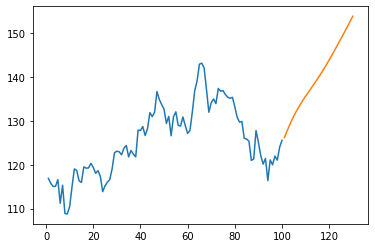

In [109]:
#visualizing predicted data of 30 days
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
plt.plot(day_new,scaler.inverse_transform(init_ip))
plt.plot(day_pred,final_pred)

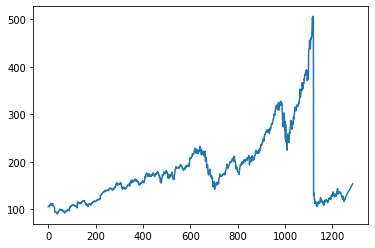

In [125]:
df2=dataf1.tolist()
df2.extend(final_pred)
plt.plot(df2)